In [31]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import Sequential
from   tensorflow.keras import layers, losses, preprocessing
from   tensorflow.keras.layers import (
    Activation, Dense, Dropout, Embedding, GlobalAveragePooling1D as GAP)
from   tensorflow.keras.layers.experimental.preprocessing import (
    TextVectorization)
from   tensorflow.keras.losses import BinaryCrossentropy as BXE

In [2]:
tf.__version__

'2.4.1'

In [3]:
DATA = '../../../../../data'

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
subdir = 'aclIMDB'
# BROKEN: requires certificate validation--downloading manually:
#dataset = tf.keras.utils.get_file(
#    'aclImdb_v1', url, untar=True, cache_dir=DATA, cache_subdir=subdir)
#dataset_dir = os.path.join(os.path.dirname(dataset), subdir)

In [5]:
dataset_dir = f'{DATA}/{subdir}'
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Using `text_dataset_from_directory` util, expects directory structure:
```
main_dir/
  class_a/
    a_text_1.txt
    a_text_2.txt
    ...
  class_b/
    b_text_1.txt
    ...
```

In [8]:
#remove_dir = os.path.join(train_dir, 'unsup')
#shutil.rmtree(remove_dir)

In [9]:
BATCH = 32
SEED = 1103

raw_training_ds = preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=BATCH, 
    validation_split=0.2, 
    subset='training', 
    seed=SEED)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch, label_batch in raw_training_ds.take(1):
    for i in range(3):
        print('Review:\n', text_batch.numpy()[i])
        print('Label:', label_batch.numpy()[i])

Review:
 b"Curly Sue is a 6 year old with an abundance of hair and a life as a drifter. She and her father, Bill (Jim Belushi), try to survive on the streets by being small time con artists. In Chicago, Bill decides to jump in front of a car in a pricey parking garage while Curly will scream about lawsuits and traction to the intended victim. It happens to be a very upscale lawyer named Grey (Kelly Lynch) who is appropriately appalled at what she has done. Not only do the scammers make some cash, they get to spend the night at Grey's plush apartment. Even then, Grey feels she owes them more so the three of them hang together for a spell. Grey only knows the lucrative law business and nothing about life. Who better to teach her than Bill and Curly, those savvy experts on life's realities? But, all good things must come to an end and there is no life for a legal expert and a couple of con men. Or is there? This is a sweet and funny movie about the unexpected. Curly is certainly as entert

In [11]:
for encoding in [0, 1]:
    print(f'Label {encoding} corresponds to '
          f'{raw_training_ds.class_names[encoding]}')

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{DATA}/aclIMDB/train', batch_size=BATCH)

Found 25000 files belonging to 2 classes.


In [13]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{DATA}/aclIMDB/test', batch_size=BATCH)

Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(
        stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [15]:
MAX_FEATURES = 10_000
SEQ_LEN = 250

In [16]:
vectorize_layer = TextVectorization(standardize=custom_standardization, 
                                    max_tokens=MAX_FEATURES,
                                    output_mode='int',
                                    output_sequence_length=SEQ_LEN)

In [17]:
# Make text-only dataset (no labes), then adapt()
train_text = raw_training_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
# Get batch of reviews and labels from data set
text_batch, label_batch = next(iter(raw_training_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f'Reveiw:\n{first_review}')
print('Label:', raw_training_ds.class_names[first_label])
print(f'Vectorized review:\n{vectorize_text(first_review, first_label)}')

Reveiw:
b'"Revolt of the Zombies" proves that having the same director revamp and recycle an idea doesn\'t necessarily make lightning strike twice.<br /><br />The Halperin brothers, responsible for the horror classic "White Zombie", made this trite piece of garbage a mere few years later to cash in on its popularity and even recycled close-ups of Lugosi\'s eyes from that previous film. There was a court battle with the "White Zombie" film\'s rights owners, who didn\'t want the Halperins to be able to use the word \'zombie\' in this title. That word was the only thing that could help this film, because, as everyone knows, bad films can make much more money simply by having the word \'Zombie\' appear in the title. Knowing what Victor Halperin was capable of a few years before only makes this uninteresting film more insulting. It seems he never directed another horror film after this debacle. The zombies here seem not to be true walking dead, but simply hypnotism victims.<br /><br />Wanna

In [20]:
for vec in [1694, 11, 89]:
    print(f'{vec} -> {vectorize_layer.get_vocabulary()[vec]}')
print('Vocab size:', len(vectorize_layer.get_vocabulary()))

1694 -> normally
11 -> i
89 -> dont
Vocab size: 10000


In [21]:
train_ds = raw_training_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
EMBED_DIM = 32

In [24]:
mod = Sequential([Embedding(MAX_FEATURES + 1, EMBED_DIM),
                  Dropout(0.2),
                  GAP(),
                  Dropout(0.2),
                  Dense(1)])
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320032    
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


In [25]:
mod.compile(loss=losses.BinaryCrossentropy(from_logits=True),
            optimizer='adam',
            metrics=tf.metrics.BinaryAccuracy(threshold=0.))

In [26]:
EPOCHS = 10
history = mod.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.6756 - binary_accuracy: 0.6606 - val_loss: 0.5640 - val_binary_accuracy: 0.7911
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5231 - binary_accuracy: 0.8082 - val_loss: 0.4186 - val_binary_accuracy: 0.8548
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3963 - binary_accuracy: 0.8601 - val_loss: 0.3446 - val_binary_accuracy: 0.8746
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3298 - binary_accuracy: 0.8815 - val_loss: 0.3026 - val_binary_accuracy: 0.8895
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2894 - binary_accuracy: 0.8949 - val_loss: 0.2740 - val_binary_accuracy: 0.8979
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2594 - binary_accuracy: 0.9044 - val_loss: 0.2525 - val_binary_accuracy: 0.9060
Epoch 7/10
625/625 [==============================] - 2s 3ms/st

In [27]:
loss, accuracy = mod.evaluate(test_ds)
loss, accuracy

782/782 [==============================] - 11s 14ms/step - loss: 0.3101 - binary_accuracy: 0.8724


(0.3100622892379761, 0.8723999857902527)

Text(0, 0.5, 'Loss')

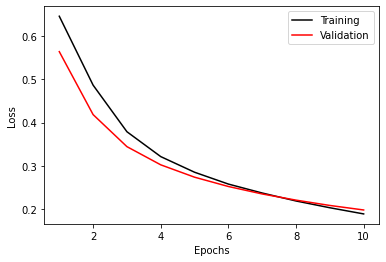

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
ep = range(1, EPOCHS + 1)

plt.plot(ep, loss, 'k', label='Training')
plt.plot(ep, val_loss, 'r', label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

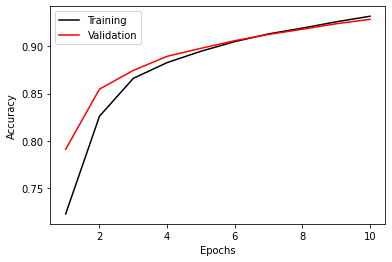

In [29]:
plt.plot(ep, acc, 'k', label='Training')
plt.plot(ep, val_acc, 'r', label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [33]:
export_mod = Sequential([vectorize_layer, mod, Activation('sigmoid')])
export_mod.compile(
    loss=BXE(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [34]:
loss, accuracy = export_mod.evaluate(raw_test_ds)
accuracy

782/782 [==============================] - 8s 10ms/step - loss: 0.3081 - accuracy: 0.8721


0.8723999857902527

In [35]:
examples = [
    'The movie was great!', 'The movie was fine', 'The movie sucked']
export_mod.predict(examples)

array([[0.6324581 ],
       [0.55118346],
       [0.43699676]], dtype=float32)

Notebook adapted from TF docs/tutorial: 
https://www.tensorflow.org/tutorials/keras/text_classification#evaluate_the_model

In [36]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.